In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.stattools import adfuller
import warnings
from sklearn.metrics import mean_absolute_error

warnings.filterwarnings("ignore")  # Suppress warnings for cleaner output


In [2]:
# Load the processed mean times
specialist_data_file = "../eda_mean_time_per_swim_event_vs_age_of_swimmer/specialist_mean_times.csv"
non_specialist_data_file = "../eda_mean_time_per_swim_event_vs_age_of_swimmer/non_specialist_mean_times.csv"

specialist_means = pd.read_csv(specialist_data_file)
non_specialist_means = pd.read_csv(non_specialist_data_file)

In [3]:
# Ensure Age is an integer (if not already)
specialist_means["Age_at_time_of_Swim"] = specialist_means["Age_at_time_of_Swim"].astype(int)
non_specialist_means["Age_at_time_of_Swim"] = non_specialist_means["Age_at_time_of_Swim"].astype(int)

# Ensure data is sorted
specialist_means = specialist_means.sort_values(by=["Event", "Age_at_time_of_Swim"])
non_specialist_means = non_specialist_means.sort_values(by=["Event", "Age_at_time_of_Swim"])

# Display sample data
print("\nSpecialist Mean Times:\n", specialist_means.head())
print("\nNon-Specialist Mean Times:\n", non_specialist_means.head())



Specialist Mean Times:
     Event  Age_at_time_of_Swim        Time Formatted_Time
0  100 BK                    6  102.240000        1:42.24
1  100 BK                    7   92.312500        1:32.31
2  100 BK                    8   80.552632        1:20.55
3  100 BK                    9   79.839394        1:19.84
4  100 BK                   10   75.102990        1:15.10

Non-Specialist Mean Times:
     Event  Age_at_time_of_Swim        Time Formatted_Time
0  100 BK                    5  102.600000        1:42.60
1  100 BK                    6   99.500000        1:39.50
2  100 BK                    7   90.210000        1:30.21
3  100 BK                    8   86.981579        1:26.98
4  100 BK                    9   81.577837        1:21.58


In [4]:
# Function to check stationarity
def check_stationarity(series):
    """Perform ADF test to check stationarity"""
    result = adfuller(series.dropna())
    return result[1] <= 0.05  # True if stationary, False otherwise



In [5]:
# Define events to exclude
excluded_events = ["50 BK", "50 FL", "50 BR", "100 IM", "800 FR"]

# Store results
results = {}


Processing Event: 100 BK
Specialist MAE: 1.7464, Non-Specialist MAE: 2.5655


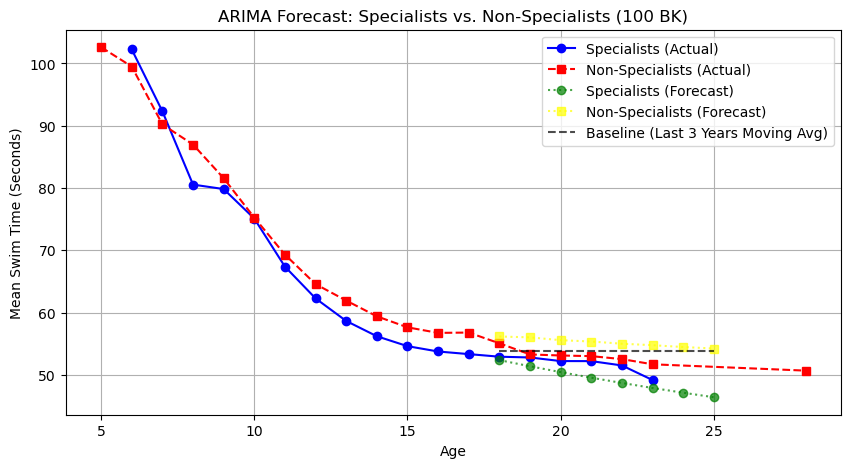


Processing Event: 100 BR
Specialist MAE: 0.3918, Non-Specialist MAE: 3.7670


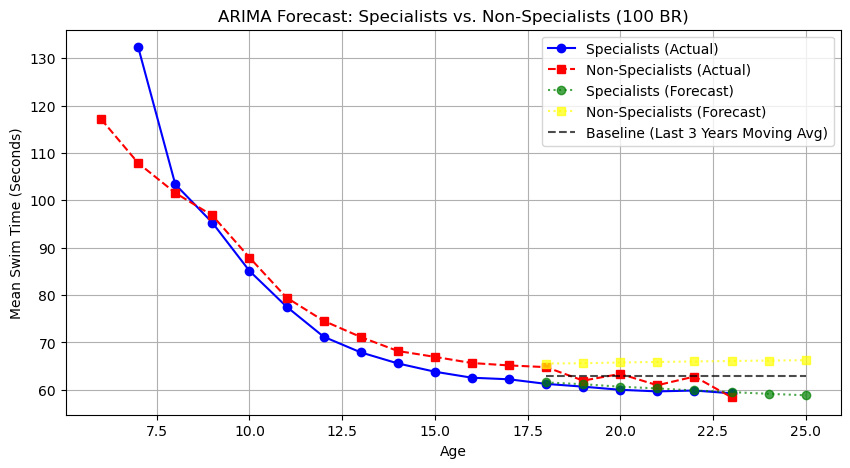


Processing Event: 100 FL
Specialist MAE: 1.5443, Non-Specialist MAE: 3.9245


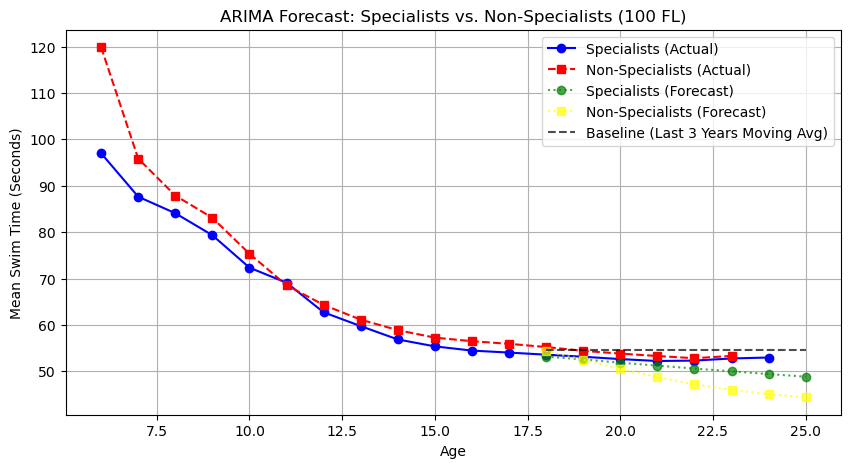


Processing Event: 100 FR
Specialist MAE: 11.3854, Non-Specialist MAE: 1.0334


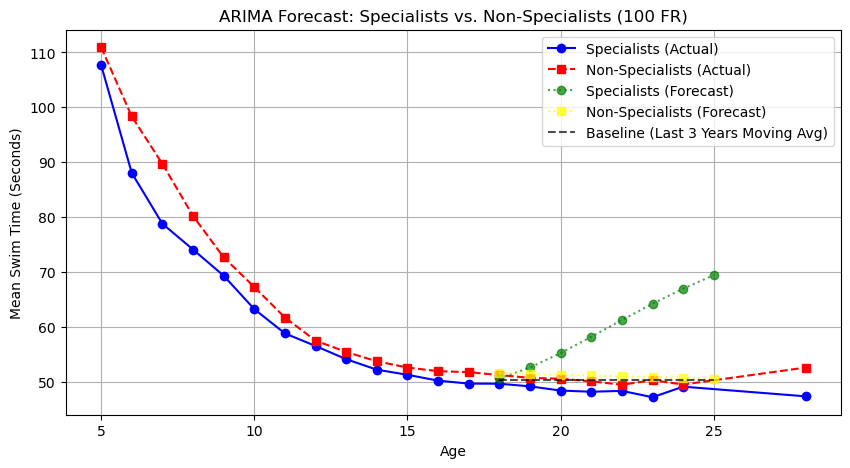


Processing Event: 1000 FR
Specialist MAE: 9.5579, Non-Specialist MAE: 17.8351


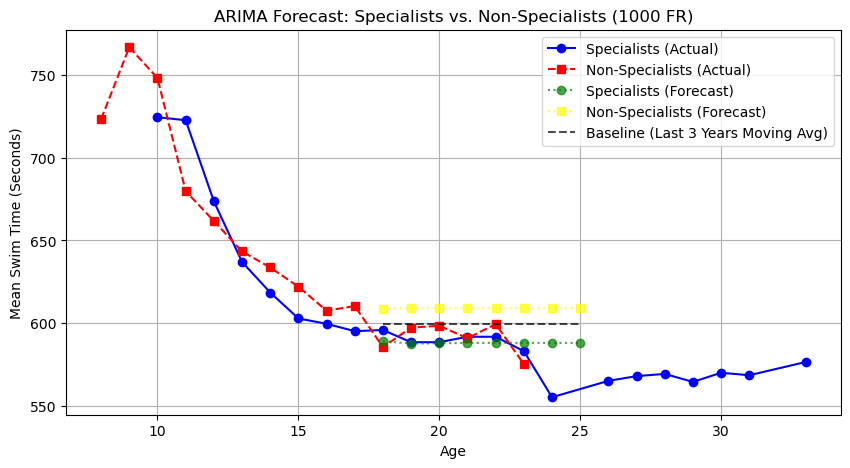


Processing Event: 1650 FR
Specialist MAE: 23.8787, Non-Specialist MAE: 43.7592


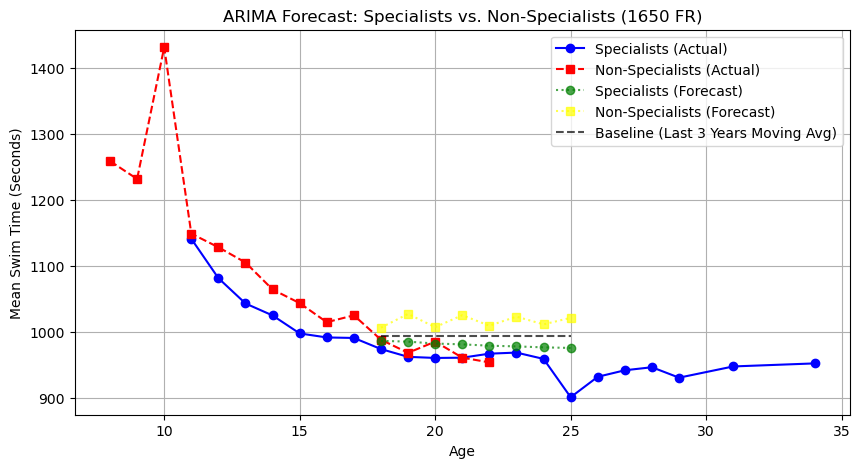


Processing Event: 200 BK
Specialist MAE: 12.6004, Non-Specialist MAE: 2.3686


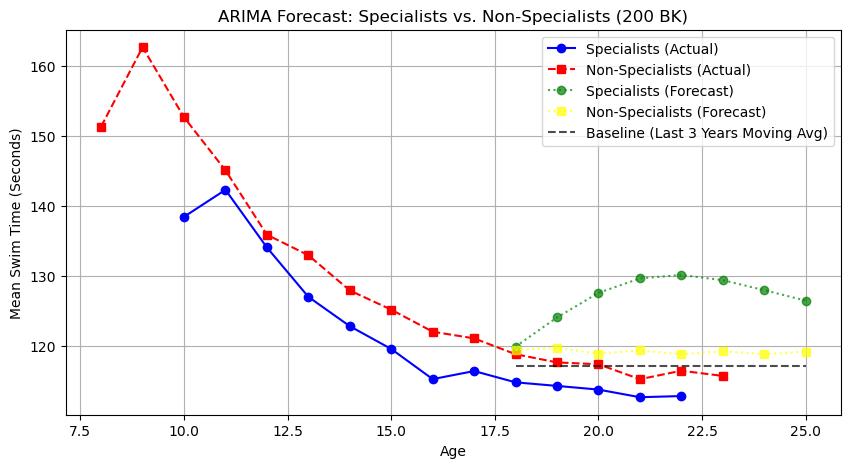


Processing Event: 200 BR
Specialist MAE: 2.3247, Non-Specialist MAE: 6.4015


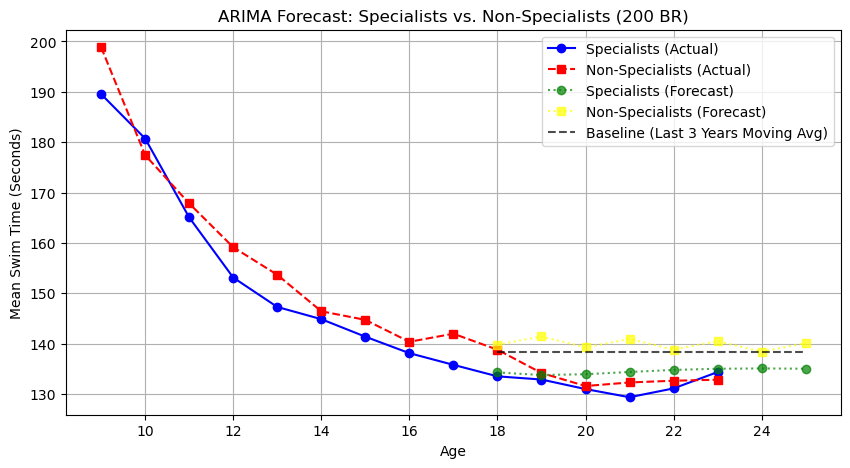


Processing Event: 200 FL
Specialist MAE: 3.0747, Non-Specialist MAE: 3.0444


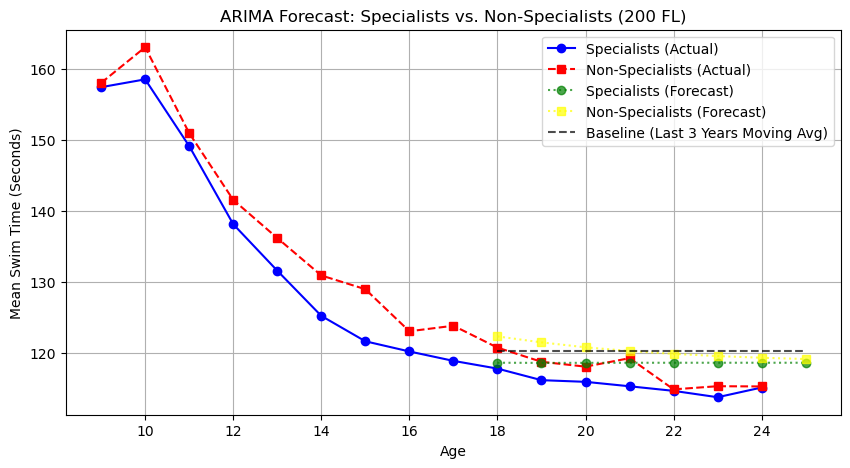


Processing Event: 200 FR
Specialist MAE: 0.3687, Non-Specialist MAE: 1.3088


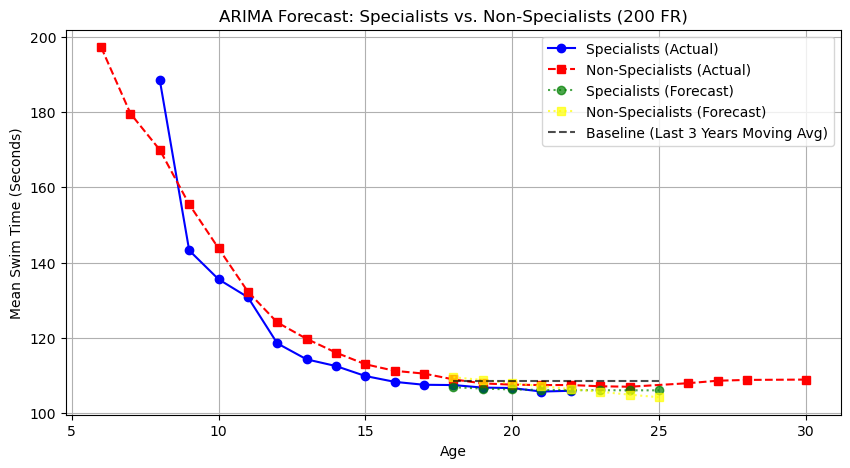


Processing Event: 200 IM
Specialist MAE: 1.7758, Non-Specialist MAE: 1.0641


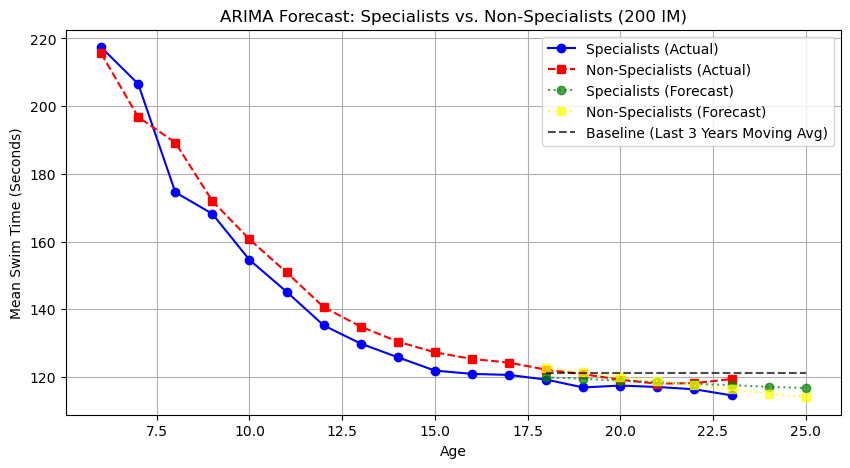


Processing Event: 400 IM
Specialist MAE: 2.4532, Non-Specialist MAE: 2.7065


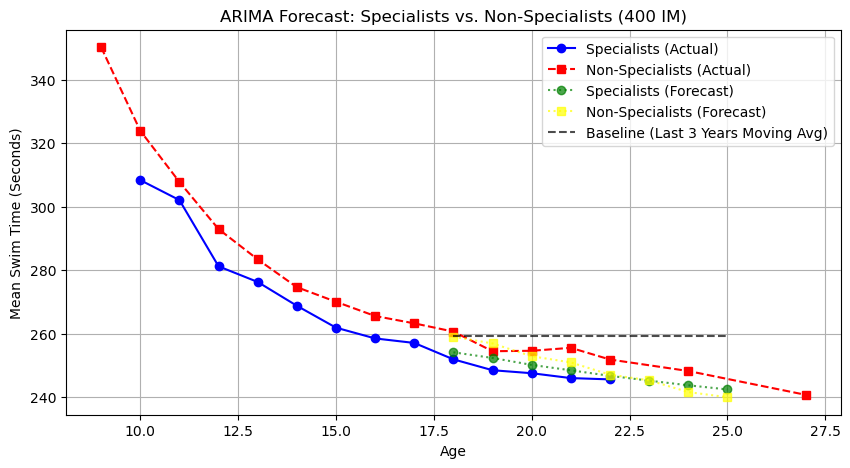


Processing Event: 50 FR
Specialist MAE: 1.0736, Non-Specialist MAE: 0.9348


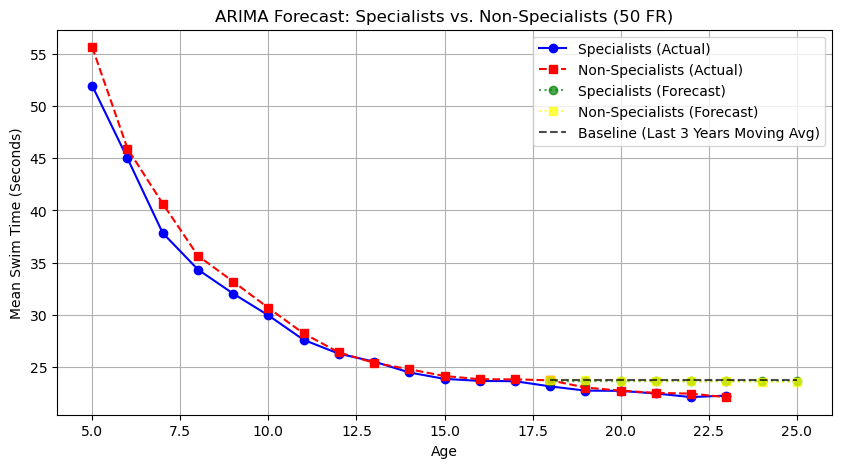


Processing Event: 500 FR
Specialist MAE: 5.7119, Non-Specialist MAE: 9.1019


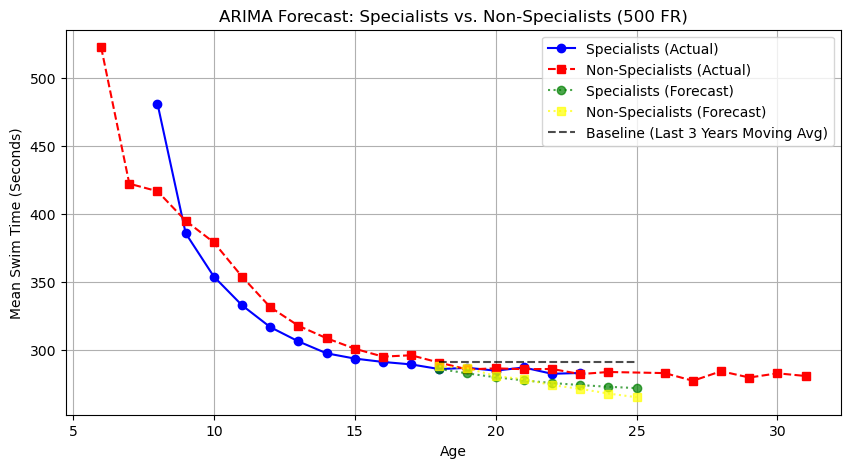

In [6]:
# Loop over all events
for event_name in specialist_means["Event"].unique():
    
    # Skip excluded events
    if event_name in excluded_events:
        print(f"Skipping {event_name} (Excluded Event)")
        continue  

    print(f"\nProcessing Event: {event_name}")

    # Filter data for this event
    spec_event_data = specialist_means[specialist_means["Event"] == event_name]
    non_spec_event_data = non_specialist_means[non_specialist_means["Event"] == event_name]

    # Set index to Age for time-series modeling
    spec_event_data = spec_event_data.set_index("Age_at_time_of_Swim")["Time"]
    non_spec_event_data = non_spec_event_data.set_index("Age_at_time_of_Swim")["Time"]

    # Train using ages ≤ 17
    spec_train = spec_event_data[spec_event_data.index <= 17]
    non_spec_train = non_spec_event_data[non_spec_event_data.index <= 17]

    # **🔹 Force Differencing to Prevent Upward Trends**
    d_spec = 1  # Force differencing to prevent long-term drift
    d_non_spec = 1

    # Fit ARIMA models with forced `d=1`
    spec_arima_model = ARIMA(spec_train, order=(2, d_spec, 1)).fit()
    non_spec_arima_model = ARIMA(non_spec_train, order=(2, d_non_spec, 1)).fit()

    # Forecasting
    forecast_horizon = 8  # Predict ages 18-26
    forecast_range = range(18, 18 + forecast_horizon)

    # Generate predictions
    spec_forecast = spec_arima_model.forecast(steps=forecast_horizon)
    non_spec_forecast = non_spec_arima_model.forecast(steps=forecast_horizon)

    # **🔹 Moving Average Baseline**
    moving_avg_baseline = spec_train.rolling(window=3).mean().iloc[-1]  # Last 3-year average
    moving_avg_array = np.full(forecast_horizon, moving_avg_baseline)

    # Compute MAE (Mean Absolute Error)
    spec_actual_future = spec_event_data[spec_event_data.index >= 18]
    non_spec_actual_future = non_spec_event_data[non_spec_event_data.index >= 18]

    # Ensure correct length for MAE calculation
    min_len = min(len(spec_actual_future), len(spec_forecast))
    spec_mae = mean_absolute_error(spec_actual_future[:min_len], spec_forecast[:min_len])

    min_len = min(len(non_spec_actual_future), len(non_spec_forecast))
    non_spec_mae = mean_absolute_error(non_spec_actual_future[:min_len], non_spec_forecast[:min_len])

    print(f"Specialist MAE: {spec_mae:.4f}, Non-Specialist MAE: {non_spec_mae:.4f}")

    # Store results
    results[event_name] = {
        "specialist_order": (2, d_spec, 1),
        "non_specialist_order": (2, d_non_spec, 1),
        "specialist_mae": spec_mae,
        "non_specialist_mae": non_spec_mae,
    }

    # Plot results
    plt.figure(figsize=(10, 5))
    plt.plot(spec_event_data.index, spec_event_data.values, marker='o', linestyle='-', label="Specialists (Actual)", color='blue')
    plt.plot(non_spec_event_data.index, non_spec_event_data.values, marker='s', linestyle='--', label="Non-Specialists (Actual)", color='red')

    plt.plot(forecast_range, spec_forecast, marker='o', linestyle='dotted', label="Specialists (Forecast)", color='green', alpha=0.7)
    plt.plot(forecast_range, non_spec_forecast, marker='s', linestyle='dotted', label="Non-Specialists (Forecast)", color='yellow', alpha=0.7)

    # **🔹 Add Moving Average Baseline**
    plt.plot(forecast_range, moving_avg_array, linestyle='dashed', color='black', label="Baseline (Last 3 Years Moving Avg)", alpha=0.7)

    plt.xlabel("Age")
    plt.ylabel("Mean Swim Time (Seconds)")
    plt.title(f"ARIMA Forecast: Specialists vs. Non-Specialists ({event_name})")
    plt.legend()
    plt.grid()
    plt.show()

In [7]:
# Print Summary of Results
print("\nFinal ARIMA Results:")
for event, res in results.items():
    print(f"{event}: Specialist MAE={res['specialist_mae']:.4f}, Non-Specialist MAE={res['non_specialist_mae']:.4f}")


Final ARIMA Results:
100 BK: Specialist MAE=1.7464, Non-Specialist MAE=2.5655
100 BR: Specialist MAE=0.3918, Non-Specialist MAE=3.7670
100 FL: Specialist MAE=1.5443, Non-Specialist MAE=3.9245
100 FR: Specialist MAE=11.3854, Non-Specialist MAE=1.0334
1000 FR: Specialist MAE=9.5579, Non-Specialist MAE=17.8351
1650 FR: Specialist MAE=23.8787, Non-Specialist MAE=43.7592
200 BK: Specialist MAE=12.6004, Non-Specialist MAE=2.3686
200 BR: Specialist MAE=2.3247, Non-Specialist MAE=6.4015
200 FL: Specialist MAE=3.0747, Non-Specialist MAE=3.0444
200 FR: Specialist MAE=0.3687, Non-Specialist MAE=1.3088
200 IM: Specialist MAE=1.7758, Non-Specialist MAE=1.0641
400 IM: Specialist MAE=2.4532, Non-Specialist MAE=2.7065
50 FR: Specialist MAE=1.0736, Non-Specialist MAE=0.9348
500 FR: Specialist MAE=5.7119, Non-Specialist MAE=9.1019
